In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

## Description

Compute subset groups of gradients and see how stable the extracted gradients are for each movies. 

GOAL: Evaluate "stability" across subsamples of subjects-generated gradients

In [2]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

In [3]:
mri_path = "./data/fmri400_compiled/"
print(os.listdir(mri_path))

movie_name   = os.listdir(mri_path)[14]
mri_df       = pd.read_csv(mri_path + movie_name)

film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
duration_film =  int(film_duration/ TR) # in number of TRs
front_pad     = int(WASH + ONSET) + 1

['TheSecretNumber_compiled.csv', 'ToClaireFromSonny_compiled.csv', 'Chatter_compiled.csv', 'LessonLearned_compiled.csv', 'Payload_compiled.csv', 'AfterTheRain_compiled.csv', 'Superhero_compiled.csv', 'Sintel_compiled.csv', 'TearsOfSteel_compiled.csv', 'BetweenViewing_compiled.csv', 'BigBuckBunny_compiled.csv', 'Rest_compiled.csv', 'YouAgain_compiled.csv', 'Spaceman_compiled.csv', 'FirstBite_compiled.csv']


## Table of Contents
- [Stability](#stable)
    - Stability across movies
    - Stability across subjects

- [Two-Factor ANOVA](#anova)

### STABILITY ACROSS MOVIES

#### Generate gradients from subsets of subjects per movie

In [77]:
subject = 13
permovie = {}
for f in os.listdir('./data/fMRIFiles/TRFiles/'):
    moviename = f.split('_')[-1][:-4]
    if moviename == 'Rest': continue
    if '400' in f and str(subject) in f:
        permovie[moviename] = np.loadtxt('./data/fMRIFiles/TRFiles/{}'.format(f), delimiter=',')

In [78]:
np.random.seed(10)
nb_per_sample = 10
movies = list(permovie.keys())
samples_names = []
samples_grad  = []
nbs = 100
for _ in range(nbs):
    samples_names.append(np.random.choice(movies, nb_per_sample, replace=False))

for i in tqdm(range(nbs)):
    concat_series = []
    for filename_movie in samples_names[i]:
        movie_series    = permovie[filename_movie]
        movie_series    = movie_series[front_pad : front_pad + duration_film]
        concat_series.append(movie_series)
    concat_series       = np.concatenate(concat_series)

    fc_movie = FC(concat_series)
    g        = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
    g.fit(fc_movie)
    samples_grad.append(g.gradients_)

save('./resources/sample_gradsubj/'+str(subject) + '_samples.pkl', samples_grad)

100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


In [79]:
samples_grad  = []
samples_label = []
for sample in os.listdir('./resources/sample_gradsubj/'):
    samples_grad.append(load('./resources/sample_gradsubj/'+sample))
    samples_label.append(sample.split('_')[0])

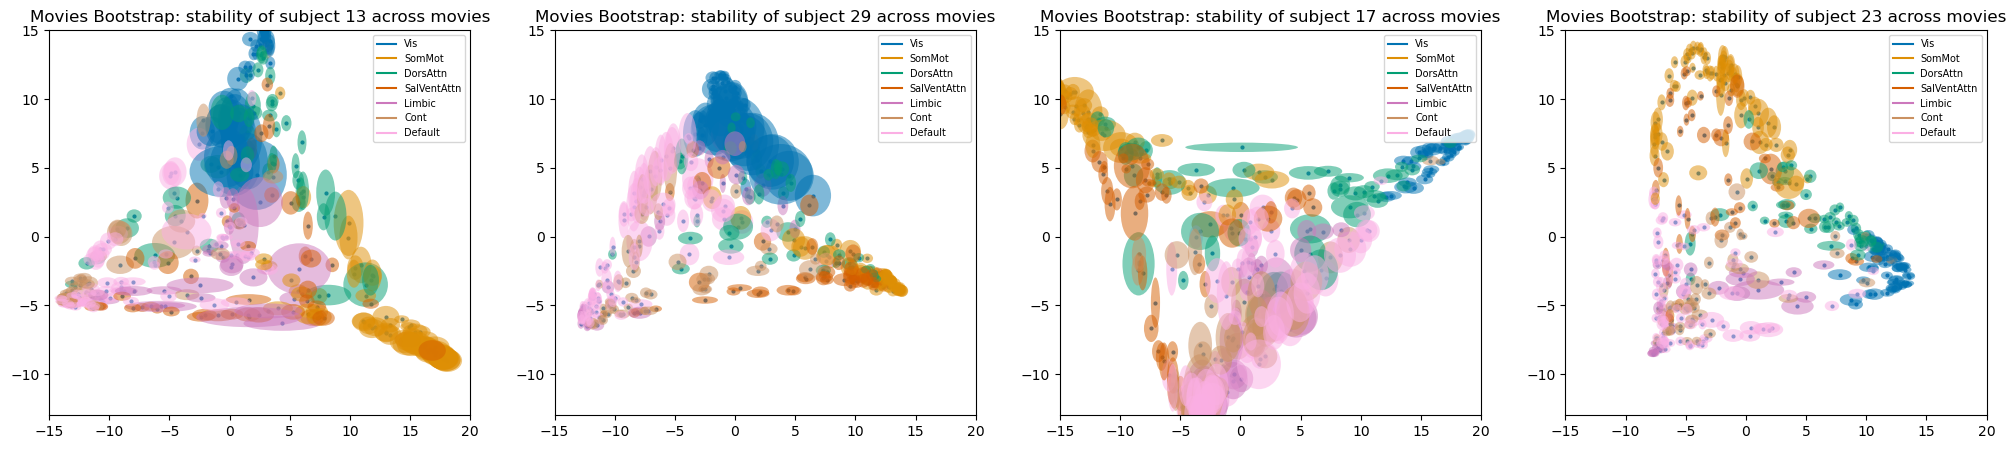

In [81]:
from brainspace.gradient import procrustes_alignment
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)


partial_region = load('./resources/region400yeo7.pkl')
colors = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}


fig, axes = plt.subplots(1,4, figsize=(25,5))
aligned_samples = []
for k in range(len(samples_grad)):

    aligned,ref      = procrustes_alignment(samples_grad[k], return_reference=True, n_iter=100)
    aligned          = np.asarray(aligned)
    aligned_samples.append(aligned)
    circle_confusion = aligned.std(axis=0)[:,[0,1]]

    axes[k].scatter(ref[:,0], ref[:,1], s=4)

    for i in range(len(circle_confusion)):
        c   = partial_region[i]
        pts = circle_confusion[i]
        m   = np.max(pts)
        # cc  = plt.Circle((ref[i][0],ref[i][1]), m ,alpha=0.5, color=colors[c])
        ellipse = Ellipse((ref[i][0],ref[i][1]), width=pts[0] * 2, height=pts[1] * 2,
                            facecolor=colors[c], alpha=0.5)

        # axes[row,col].add_artist(cc)
        axes[k].add_patch(ellipse)

    axes[k].set_title("Movies Bootstrap: stability of subject {} across movies".format(samples_label[k]), size=12)

    C       = list(colors.values())
    labels  = list(colors.keys())
    dummies = [axes[k].plot([], [], ls='-', c=c)[0] for c in C]
    axes[k].legend(dummies, labels, loc=1, prop={'size':7})
    axes[k].set_xlim(-15,20)
    axes[k].set_ylim(-13,15)
plt.show()

### STABILITY ACROSS SUBJECTS

#### Generate gradients from subsets of subjects per movie

In [ ]:
nb_per_sample = 25
subjects      = [c for c in mri_df.filename.unique() if '400' in c]
samples_names = []
samples_grad  = []
nbs = 10
for _ in range(nbs):
    samples_names.append(np.random.choice(subjects, nb_per_sample, replace=False))

for i in tqdm(range(nbs)):
    concat_series = []
    for filename_movie in samples_names[i]:
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)
        movie_series    = movie_series[front_pad : front_pad + duration_film]
        concat_series.append(movie_series)
    concat_series       = np.concatenate(concat_series)

    fc_movie = FC(concat_series)
    g        = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
    g.fit(fc_movie)
    samples_grad.append(g.gradients_)

# save('./resources/sample_grad/'+movie_name.split('_')[0] + '_samples.pkl', samples_grad)

100%|██████████| 10/10 [02:13<00:00, 13.34s/it]


#### Visualize Variance across Sampled Gradients for each Movies

In [73]:
samples_grad  = []
samples_label = []
for sample in os.listdir('./resources/sample_grad/'):
    samples_grad.append(load('./resources/sample_grad/'+sample))
    samples_label.append(sample.split('_')[0])

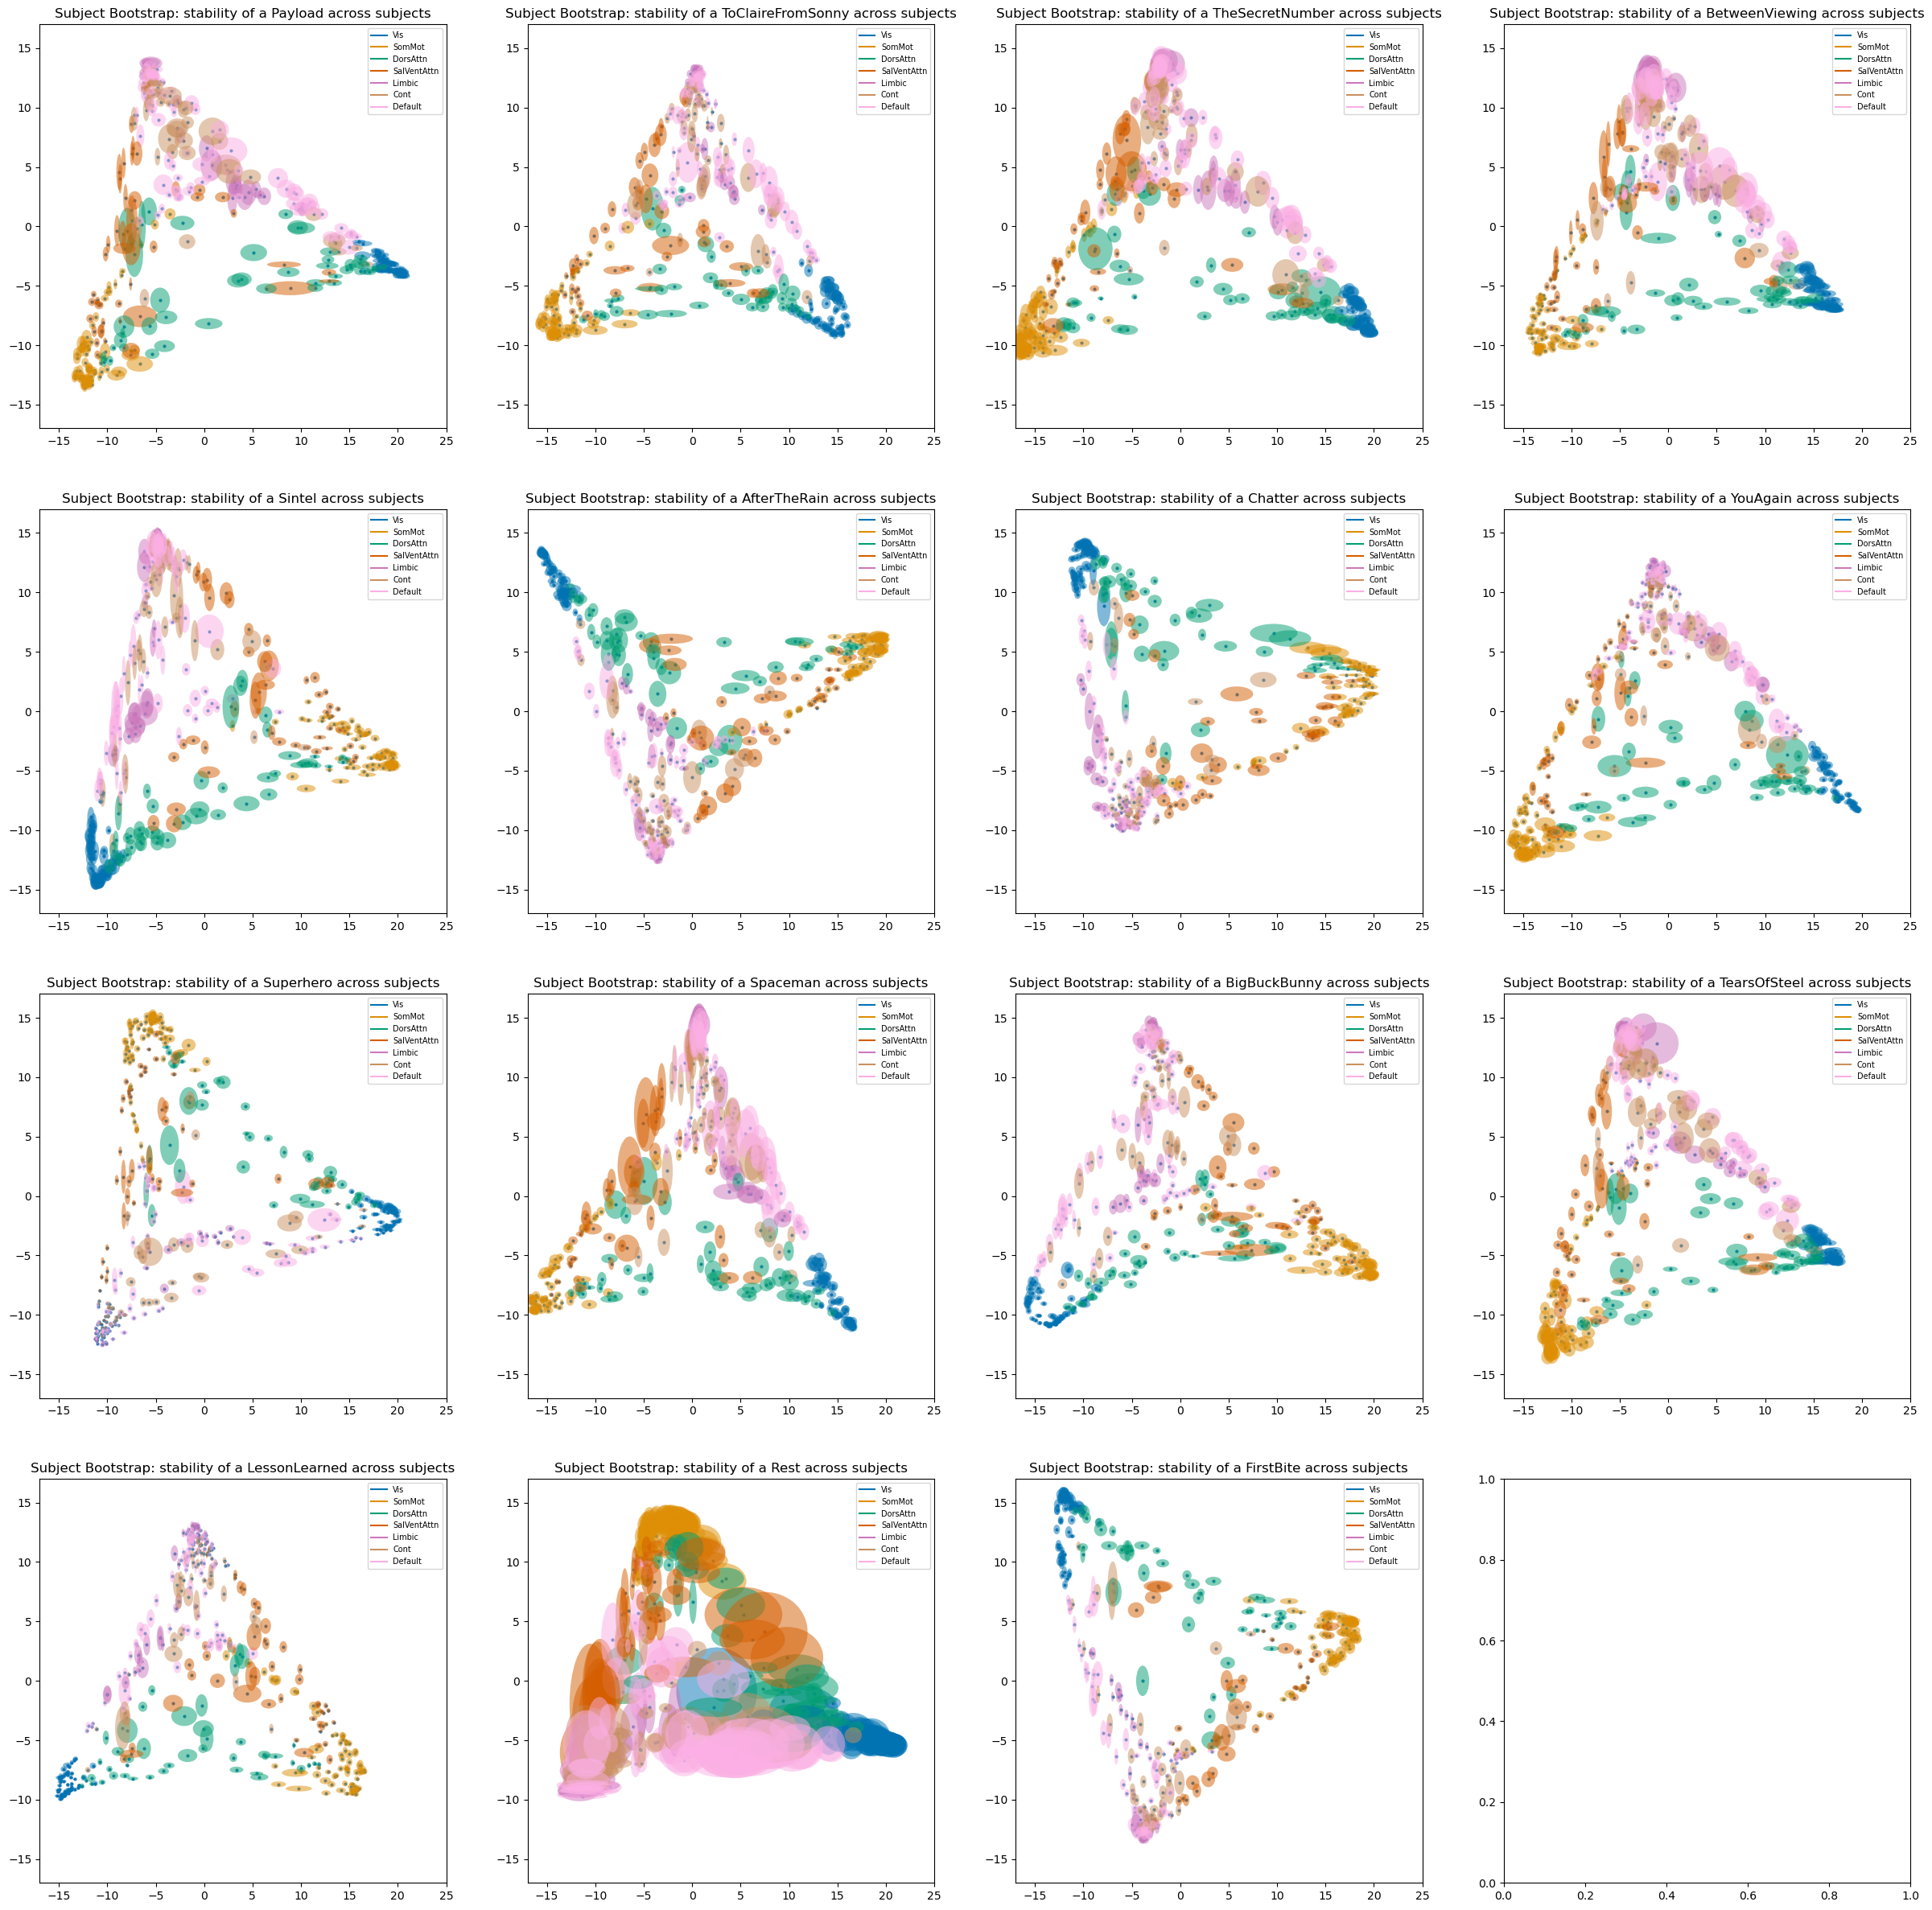

In [74]:
from brainspace.gradient import procrustes_alignment
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)


partial_region = load('./resources/region400yeo7.pkl')
colors = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}
# colors         = {'Vis': my_cmap.colors[idx], 'Default':'tab:orange', 'Cont':'tab:green', 'DorsAttn':'tab:red', 'Limbic':'tab:purple', 'SalVentAttn': 'tab:brown', 'SomMot': 'tab:pink'}


fig, axes = plt.subplots(4,4, figsize=(30,30))
aligned_samples = []
for k in range(len(samples_grad)):
    row,col = k//4, k%4

    aligned,ref      = procrustes_alignment(samples_grad[k], return_reference=True, n_iter=100)
    aligned          = np.asarray(aligned)
    aligned_samples.append(aligned)
    circle_confusion = aligned.std(axis=0)[:,[0,1]]

    axes[row,col].scatter(ref[:,0], ref[:,1], s=4)

    for i in range(len(circle_confusion)):
        c   = partial_region[i]
        pts = circle_confusion[i]
        m   = np.max(pts)
        # cc  = plt.Circle((ref[i][0],ref[i][1]), m ,alpha=0.5, color=colors[c])
        ellipse = Ellipse((ref[i][0],ref[i][1]), width=pts[0] * 2, height=pts[1] * 2,
                            facecolor=colors[c], alpha=0.5)

        # axes[row,col].add_artist(cc)
        axes[row,col].add_patch(ellipse)

    axes[row,col].set_title("Subject Bootstrap: stability of a {} across subjects".format(samples_label[k]), size=12)

    C       = list(colors.values())
    labels  = list(colors.keys())
    dummies = [axes[row,col].plot([], [], ls='-', c=c)[0] for c in C]
    axes[row,col].legend(dummies, labels, loc=1, prop={'size':7})
    axes[row,col].set_xlim(-17,25)
    axes[row,col].set_ylim(-17,17)

plt.show()

#### Visualize Aggregated variance for each Movies 

(0.0, 4.0)

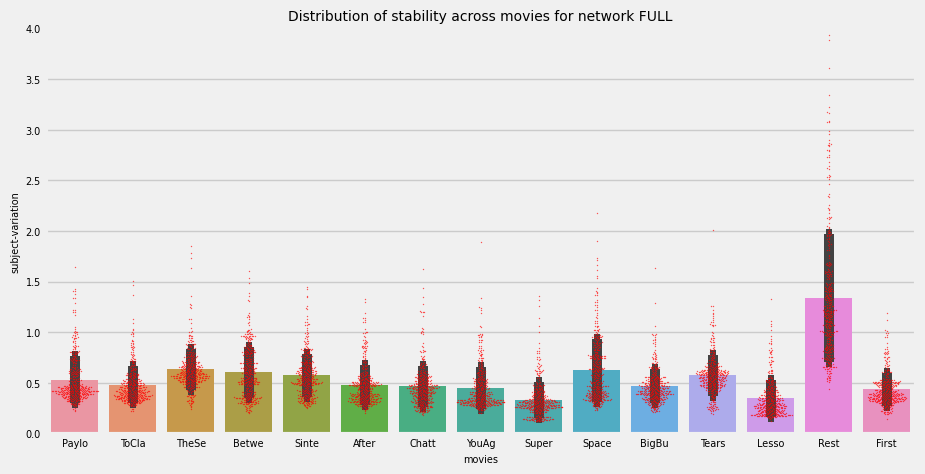

In [14]:
# Close-up view of a full network variation across subjects
fig, ax = plt.subplots(1,1, figsize=(10,5))
distrib = np.asarray(aligned_samples).std(axis=1)[...,[0,1]].mean(axis=-1)
concat_sample_labels  = []
for i in range(len(distrib)):
    concat_sample_labels += [samples_label[i][:5]] * distrib.shape[1]

corr_score = {'movies': concat_sample_labels, 'subject-variation': distrib.flatten()}

sns.barplot(ax=ax, x="movies", y="subject-variation", data=corr_score, capsize=.1, errorbar="sd")
sns.swarmplot(ax=ax, x="movies", y="subject-variation", data=corr_score, color="r", alpha=.65, size=1)
ax.tick_params(labelsize=7)
ax.set_xlabel('movies', fontsize=7)
ax.set_ylabel('subject-variation', fontsize=7)
ax.set_title("Distribution of stability across movies for network {}".format('FULL'), size=10)
ax.set_ylim(0,4)

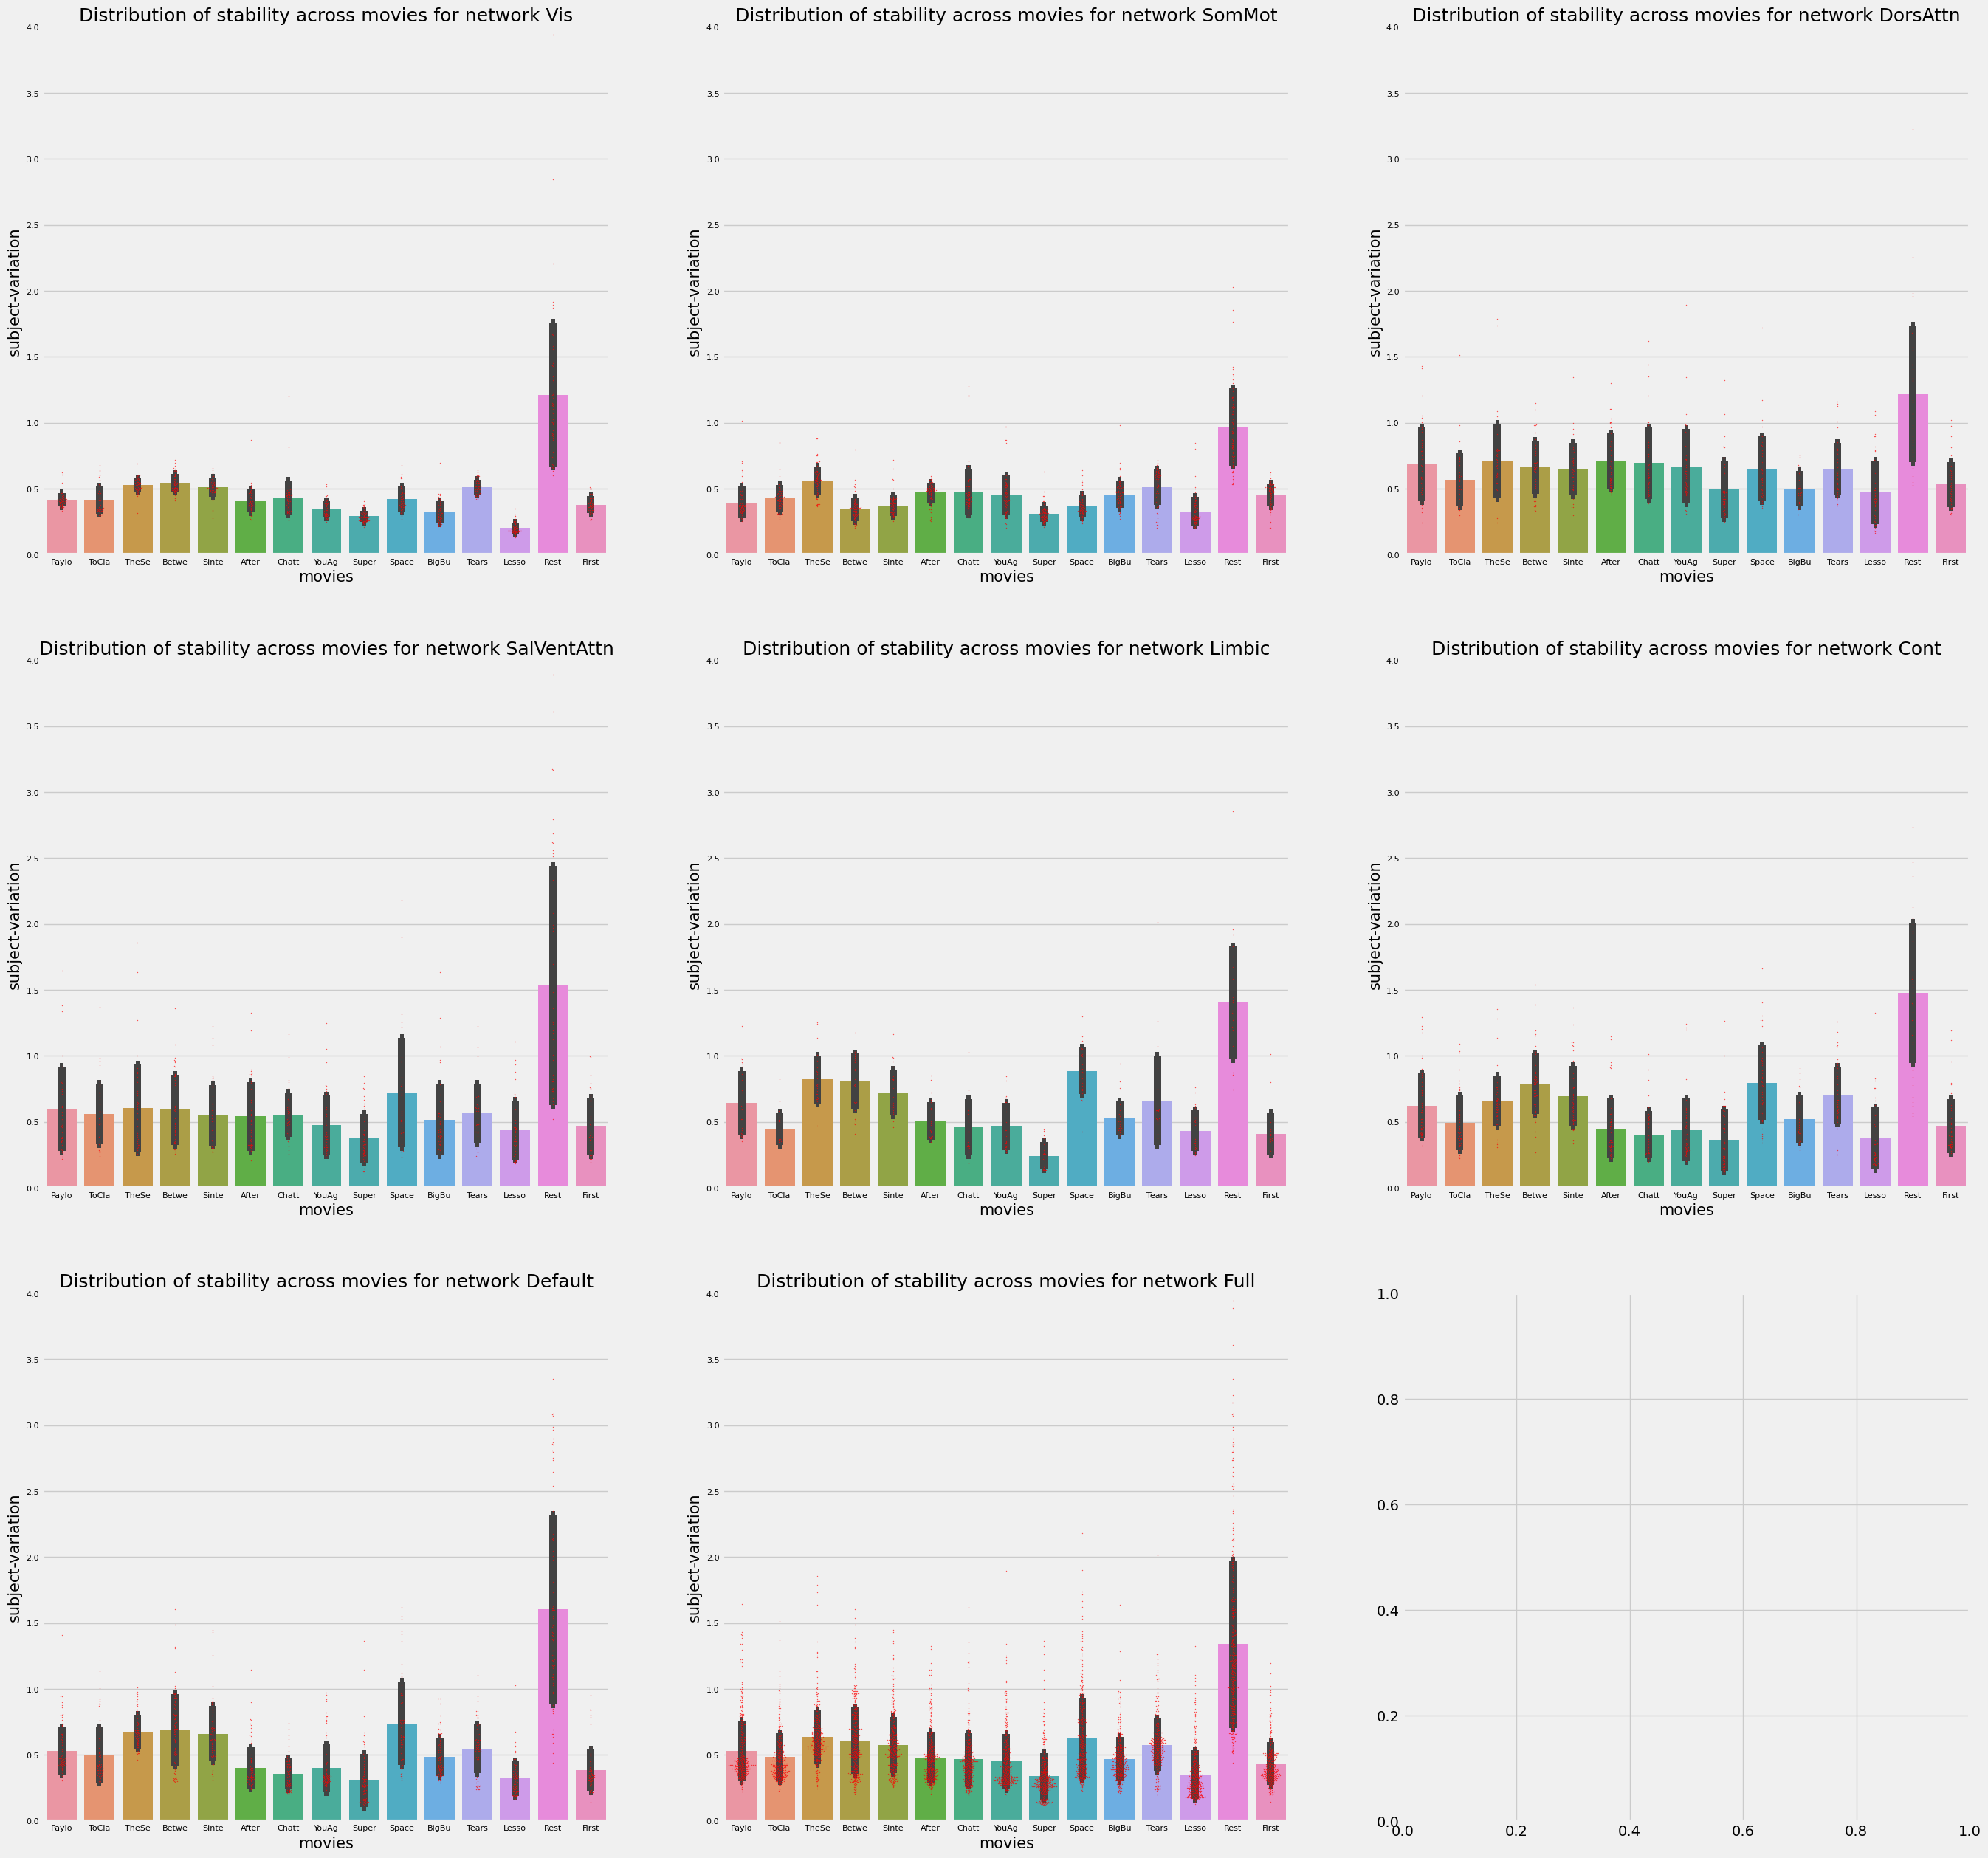

In [15]:
# ALL views of networks variation across subjects
partial_region = load('./resources/yeo7region400.pkl')
fig, ax = plt.subplots(3,3, figsize=(30,30))

for idx,r in enumerate(partial_region):
    row, col = idx//3, idx%3
    distrib = np.asarray(aligned_samples)[:,:,partial_region[r]].std(axis=1)[...,[0,1]].mean(axis=-1)
    concat_sample_labels  = []
    for i in range(len(distrib)):
        concat_sample_labels += [samples_label[i][:5]] * distrib.shape[1]

    corr_score = {'movies': concat_sample_labels, 'subject-variation': distrib.flatten()}

    sns.barplot(ax=ax[row,col], x="movies", y="subject-variation", data=corr_score, capsize=.1, errorbar="sd")
    sns.swarmplot(ax=ax[row,col], x="movies", y="subject-variation", data=corr_score, color="r", alpha=.65, size=1)
    ax[row,col].tick_params(labelsize=8)
    ax[row,col].set_xlabel('movies', fontsize=15)
    ax[row,col].set_ylabel('subject-variation', fontsize=15)
    ax[row,col].set_title("Distribution of stability across movies for network {}".format(r), size=18)
    ax[row,col].set_ylim(0,4)

idx += 1
row, col = idx//3, idx%3
distrib = np.asarray(aligned_samples).std(axis=1)[...,[0,1]].mean(axis=-1)
concat_sample_labels  = []
for i in range(len(distrib)):
    concat_sample_labels += [samples_label[i][:5]] * distrib.shape[1]

corr_score = {'movies': concat_sample_labels, 'subject-variation': distrib.flatten()}

sns.barplot(ax=ax[row,col], x="movies", y="subject-variation", data=corr_score, capsize=.1, errorbar="sd")
sns.swarmplot(ax=ax[row,col], x="movies", y="subject-variation", data=corr_score, color="r", alpha=.65, size=1)
ax[row,col].tick_params(labelsize=8)
ax[row,col].set_xlabel('movies', fontsize=15)
ax[row,col].set_ylabel('subject-variation', fontsize=15)
ax[row,col].set_title("Distribution of stability across movies for network {}".format('Full'), size=18)
ax[row,col].set_ylim(0,4)

plt.show()

### ANOVA One factor on the 2 factors "subject" and "movies" and ANOVA Two factors

In [13]:
from bioinfokit.analys import stat

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [14]:
dct = {}
for file in os.listdir('./resources/static_grad/individual_level/'):
    tmp = load('./resources/static_grad/individual_level/'+file)
    dct[file[:-4].split('_')[0]] = tmp

all_grad = [list(k.values()) for k in list(dct.values())]
all_grad = np.asarray(all_grad)[...,:2]
all_grad = np.concatenate(all_grad)

# Compute reference grad to align on 
tmpalign, ref, score = procrustes_align(all_grad)

Example of 1 Anova test on 1 region/parcel

In [27]:
# Generate dataframe for ANOVA
movies = list(dct.keys())
subjects = list(dct[movies[0]].keys())
df = {"score": [], "Subject": [], "Movie": []}
for m in movies:
    for s in subjects:
        cur_grad = dct[m][s][:,:2]
        cur_grad = procrustes_align([cur_grad], ref=ref)[0][0]
        
        dist = points_distance(cur_grad[0],cur_grad.mean(axis=0), pmethod="L2")

        df['score'].append(dist)
        # df['score'].append(network_volume(cur_grad, "all"))
        # df['score'].append(cur_grad[:,1].max()-cur_grad[:,1].min())
        df['Subject'].append(s)
        df['Movie'].append(m)

df = pd.DataFrame.from_dict(df)

In [28]:
lm = ols("score ~ C(Subject) * C(Movie)", data=df).fit()

reg1 = anova_lm(ols("score ~ C(Subject) + C(Movie)", data=df).fit(), lm)
reg2 = anova_lm(
        ols("score ~ C(Subject)", data=df).fit(),
        ols("score ~ C(Subject) + C(Movie, Sum)", data=df).fit(),
        )
reg3 = anova_lm(
        ols("score ~ C(Movie)", data=df).fit(),
        ols("score ~ C(Subject) + C(Movie, Sum)", data=df).fit(),
    )

In [29]:
res = stat()
res.anova_stat(df=df[['score','Movie']], res_var='score', anova_model='score ~ C(Movie)')
# res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
print(res.anova_summary)

res = stat()
res.anova_stat(df=df[['score','Subject']], res_var='score', anova_model='score ~ C(Subject)')
# res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
print(res.anova_summary)

             df       sum_sq    mean_sq         F    PR(>F)
C(Movie)   13.0   540.513091  41.577930  3.347072  0.000068
Residual  406.0  5043.405679  12.422181       NaN       NaN
               df       sum_sq    mean_sq         F        PR(>F)
C(Subject)   29.0  1720.739602  59.335848  5.990139  5.449989e-18
Residual    390.0  3863.179168   9.905588       NaN           NaN


Post-HOC factor levels effect check

In [30]:
res = stat()
res.tukey_hsd(df=df[['score','Subject']], res_var='score', xfac_var='Subject', anova_model='score ~ C(Subject)')
proc = res.tukey_summary

res = stat()
res.tukey_hsd(df=df[['score','Movie']], res_var='score', xfac_var='Movie', anova_model='score ~ C(Movie)')
proc2 = res.tukey_summary

1-way anova across movies and rest to obtain F-Scores for identifiability

In [ ]:
# withrest_fscore_movie = {m:{} for m in movies}
# cutoff = 0.05/400
# for m in movies:
#     for i in tqdm(range(400)):
#         df = {"score": [], "Subject": []}
#         for s in subjects:
#             cur_grad = dct[m][s][:,:2]
#             cur_grad = procrustes_align([cur_grad], ref=ref)[0][0]

#             dist = points_distance(cur_grad[i],cur_grad.mean(axis=0), pmethod="L2")

#             df['score'].append(dist)
#             df['Subject'].append(s)

#         df = pd.DataFrame.from_dict(df)
#         res = stat()
#         res.anova_stat(df=df, res_var='score', anova_model='score ~ C(Subject)')
#         # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
#         if res.anova_summary.iloc[0,-1] < cutoff:
#             withrest_fscore_movie[m][i][0] = res.anova_summary.iloc[0,-2]

F-Score Maps Subject and Movies (cond1: including rest, cond2: not including rest) SCORE: distance to gradient centroid

In [7]:
# CONDITION1: including rest
# Generate dataframe for ANOVA
movies = list(dct.keys())
subjects = list(dct[movies[0]].keys())
cutoff = 0.05/400
withrest_fscore = np.zeros((400,2))
for i in tqdm(range(400)):
        df = {"score": [], "Subject": [], "Movie": []}
        for m in movies:
                for s in subjects:
                        cur_grad = dct[m][s][:,:2]
                        cur_grad = procrustes_align([cur_grad], ref=ref)[0][0]
                        
                        dist = points_distance(cur_grad[i],cur_grad.mean(axis=0), pmethod="L2")

                        df['score'].append(dist)
                        # df['score'].append(network_volume(cur_grad, "all"))
                        # df['score'].append(cur_grad[:,1].max()-cur_grad[:,1].min())
                        df['Subject'].append(s)
                        df['Movie'].append(m)

        df = pd.DataFrame.from_dict(df)

        # lm = ols("score ~ C(Subject) * C(Movie)", data=df).fit()

        # reg1 = anova_lm(ols("score ~ C(Subject) + C(Movie)", data=df).fit(), lm)
        # reg2 = anova_lm(
        #         ols("score ~ C(Subject)", data=df).fit(),
        #         ols("score ~ C(Subject) + C(Movie, Sum)", data=df).fit(),
        #         )
        # reg3 = anova_lm(
        #         ols("score ~ C(Movie)", data=df).fit(),
        #         ols("score ~ C(Subject) + C(Movie, Sum)", data=df).fit(),
        # )
        # if reg2.iloc[-1,-1] < 0.001:
        #         withrest_fscore[i][0] = reg2.iloc[-1,-2]
        # if reg3.iloc[-1,-1] < 0.001:
        #         withrest_fscore[i][1] = reg3.iloc[-1,-2]

        res = stat()
        res.anova_stat(df=df[['score','Movie']], res_var='value', anova_model='score ~ C(Movie)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withrest_fscore[i][0] = res.anova_summary.iloc[0,-2]

        res = stat()
        res.anova_stat(df=df[['score','Subject']], res_var='value', anova_model='score ~ C(Subject)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withrest_fscore[i][1] = res.anova_summary.iloc[0,-2]

100%|██████████| 400/400 [00:34<00:00, 11.46it/s]


In [8]:
# CONDITION 2: not including rest
# Generate dataframe for ANOVA
movies = list(dct.keys())
subjects = list(dct[movies[0]].keys())
cutoff = 0.05/400
withoutrest_fscore = np.zeros((400,2))
for i in tqdm(range(400)):
        df = {"score": [], "Subject": [], "Movie": []}
        for m in movies:
                if m == "Rest": continue
                for s in subjects:
                        cur_grad = dct[m][s][:,:2]
                        cur_grad = procrustes_align([cur_grad], ref=ref)[0][0]
                        
                        dist = points_distance(cur_grad[i],cur_grad.mean(axis=0), pmethod="L2")

                        df['score'].append(dist)
                        # df['score'].append(network_volume(cur_grad, "all"))
                        # df['score'].append(cur_grad[:,1].max()-cur_grad[:,1].min())
                        df['Subject'].append(s)
                        df['Movie'].append(m)

        df = pd.DataFrame.from_dict(df)

        # lm = ols("score ~ C(Subject) * C(Movie)", data=df).fit()

        # reg1 = anova_lm(ols("score ~ C(Subject) + C(Movie)", data=df).fit(), lm)
        # reg2 = anova_lm(
        #         ols("score ~ C(Subject)", data=df).fit(),
        #         ols("score ~ C(Subject) + C(Movie, Sum)", data=df).fit(),
        #         )
        # reg3 = anova_lm(
        #         ols("score ~ C(Movie)", data=df).fit(),
        #         ols("score ~ C(Subject) + C(Movie, Sum)", data=df).fit(),
        # )
        # if reg2.iloc[-1,-1] < 0.001:
        #         withrest_fscore[i][0] = reg2.iloc[-1,-2]
        # if reg3.iloc[-1,-1] < 0.001:
        #         withrest_fscore[i][1] = reg3.iloc[-1,-2]

        res = stat()
        res.anova_stat(df=df[['score','Movie']], res_var='value', anova_model='score ~ C(Movie)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withoutrest_fscore[i][0] = res.anova_summary.iloc[0,-2]

        res = stat()
        res.anova_stat(df=df[['score','Subject']], res_var='value', anova_model='score ~ C(Subject)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withoutrest_fscore[i][1] = res.anova_summary.iloc[0,-2]

100%|██████████| 400/400 [00:32<00:00, 12.40it/s]


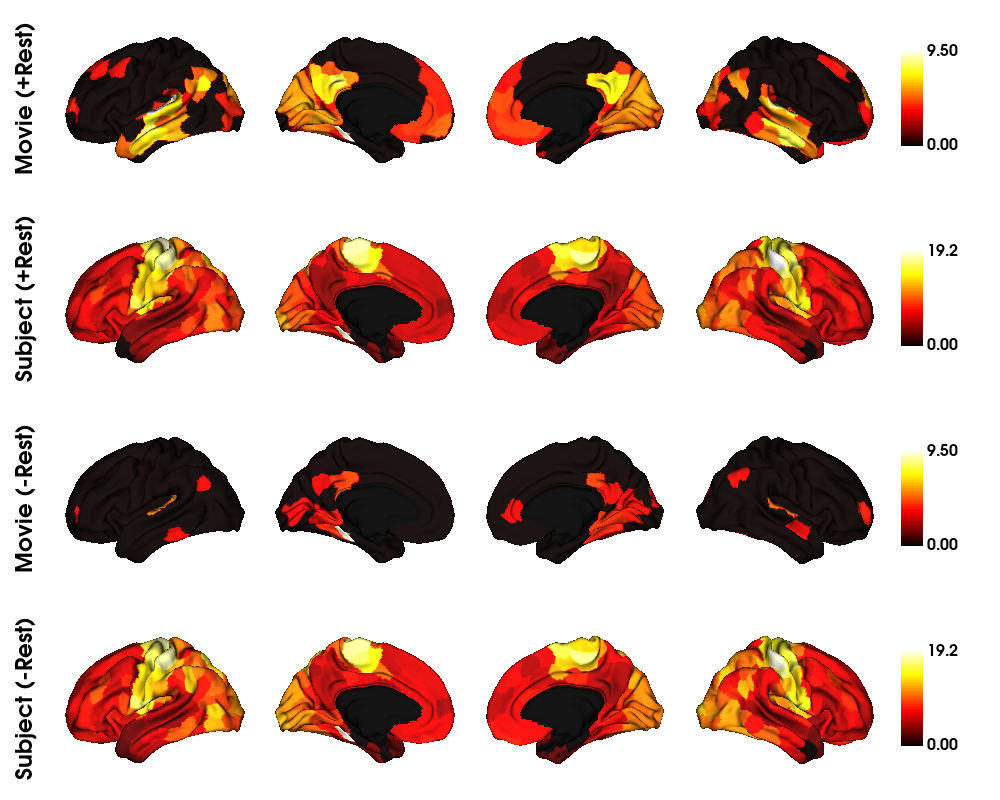

In [9]:
# For a single movie: plots correlation of parcels versus emotions series
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

gs   = np.concatenate([withrest_fscore, withoutrest_fscore], axis=1).T

grad = [None] * 4
for k in range(gs.shape[0]):
    # map the gradient to the parcels
    # gs[k][0]   = gs.min()
    if k in [0,2]:
        gs[k][1]   = gs[[0,2]].max()
    else:
        gs[k][1]   = gs[[1,3]].max()
    grad[k] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 800), cmap='hot',
                 color_bar=True, label_text=['Movie (+Rest)', 'Subject (+Rest)', 'Movie (-Rest)', 'Subject (-Rest)'], zoom=1.15, embed_nb=True, interactive=False,
                 transparent_bg=False)

F-Score Maps Subject and Movies (cond1: including rest, cond2: not including rest) SCORE: distance to gradient centroid

In [10]:
# CONDITION1: including rest
# Generate dataframe for ANOVA
movies = list(dct.keys())
subjects = list(dct[movies[0]].keys())
cutoff = 0.05/400
withrest_fscore = np.zeros((400,2))
for i in tqdm(range(400)):
        df = {"score": [], "Subject": [], "Movie": []}
        for m in movies:
                for s in subjects:
                        cur_grad = dct[m][s][:,:2]
                        cur_grad = procrustes_align([cur_grad], ref=ref)[0][0]
                        
                        dist = cur_grad[i][0]

                        df['score'].append(dist)
                        df['Subject'].append(s)
                        df['Movie'].append(m)

        df = pd.DataFrame.from_dict(df)

        res = stat()
        res.anova_stat(df=df[['score','Movie']], res_var='value', anova_model='score ~ C(Movie)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withrest_fscore[i][0] = res.anova_summary.iloc[0,-2]

        res = stat()
        res.anova_stat(df=df[['score','Subject']], res_var='value', anova_model='score ~ C(Subject)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withrest_fscore[i][1] = res.anova_summary.iloc[0,-2]

100%|██████████| 400/400 [00:30<00:00, 12.96it/s]


In [11]:
# CONDITION 2: not including rest
# Generate dataframe for ANOVA
movies = list(dct.keys())
subjects = list(dct[movies[0]].keys())
cutoff = 0.05/400
withoutrest_fscore = np.zeros((400,2))
for i in tqdm(range(400)):
        df = {"score": [], "Subject": [], "Movie": []}
        for m in movies:
                if m == "Rest": continue
                for s in subjects:
                        cur_grad = dct[m][s][:,:2]
                        cur_grad = procrustes_align([cur_grad], ref=ref)[0][0]
                        
                        dist = cur_grad[i][0]

                        df['score'].append(dist)
                        df['Subject'].append(s)
                        df['Movie'].append(m)

        df = pd.DataFrame.from_dict(df)

        res = stat()
        res.anova_stat(df=df[['score','Movie']], res_var='value', anova_model='score ~ C(Movie)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withoutrest_fscore[i][0] = res.anova_summary.iloc[0,-2]

        res = stat()
        res.anova_stat(df=df[['score','Subject']], res_var='value', anova_model='score ~ C(Subject)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withoutrest_fscore[i][1] = res.anova_summary.iloc[0,-2]

100%|██████████| 400/400 [00:28<00:00, 13.81it/s]


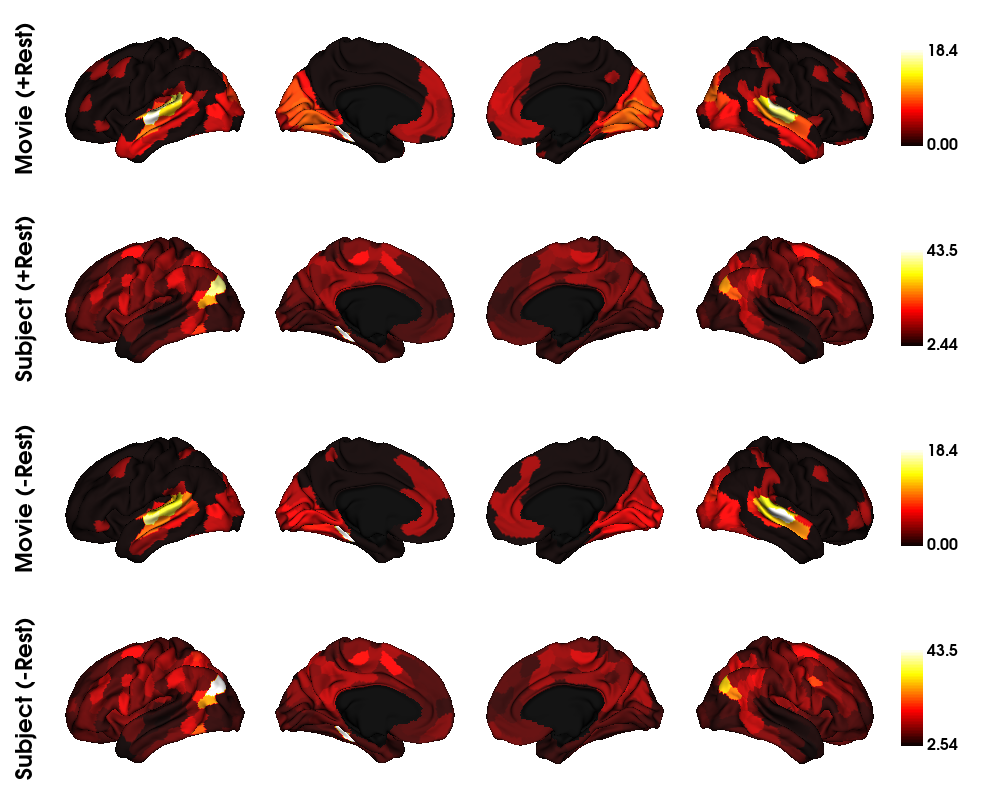

In [12]:
# For a single movie: plots correlation of parcels versus emotions series
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

gs   = np.concatenate([withrest_fscore, withoutrest_fscore], axis=1).T

grad = [None] * 4
for k in range(gs.shape[0]):
    # map the gradient to the parcels
    # gs[k][0]   = gs.min()
    if k in [0,2]:
        gs[k][1]   = gs[[0,2]].max()
    else:
        gs[k][1]   = gs[[1,3]].max()
    grad[k] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 800), cmap='hot',
                 color_bar=True, label_text=['Movie (+Rest)', 'Subject (+Rest)', 'Movie (-Rest)', 'Subject (-Rest)'], zoom=1.15, embed_nb=True, interactive=False,
                 transparent_bg=False)